In [1]:
import sys
sys.path.append("..")
import os

from tqdm import tqdm
import h5py

import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.reset_orig()


In [2]:
from coda.utils.postprocessing import (
    load_data_assimilation_network, 
    load_hydra_config,
    reconstruct_observations,
)
from coda.datamodule.DataLoader import L96InferenceDataset
from coda.datamodule.observational_models import RandomObservationModel
from mdml_tools.simulators.lorenz96 import L96Simulator

In [3]:
baseline_dir = "/gpfs/home/zinchenk/dev/hidden-process-learning/notebooks/baseline_data_assimilation_l96_one_level"
experiment_dir = "/gpfs/work/zinchenk/final_experiments/120324_try_batch_norm/data_assimilation/multirun/2024-03-12/22-03-06/5"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
ground_truths = []
observations = []
mask = []
analysis_enks = []
analysis_oi = []

files = os.listdir(baseline_dir)
files = [file for file in files if file.endswith(".npy")]
for file in files:
    baseline = np.load(os.path.join(baseline_dir, file), allow_pickle=True).item()
    ground_truths.append(baseline["simulation"])
    observations.append(baseline["observations"])
    the_mask = observations[-1] == 0
    mask.append(the_mask)
    analysis_enks.append(baseline["enks_perturb_obs"])
    analysis_oi.append(baseline["optimal_interpolation"])

ground_truths = torch.tensor(np.stack(ground_truths)).float()
observations = torch.tensor(np.stack(observations)).float()
mask = torch.logical_not(torch.tensor(np.stack(mask))).float()
analysis_enks = torch.tensor(np.stack(analysis_enks)).float()
analysis_oi = torch.tensor(np.stack(analysis_oi)).float()

In [6]:
assimilation_network = load_data_assimilation_network(experiment_dir, device=device)
config = load_hydra_config(experiment_dir)

In [7]:
# instantiate observational model
observational_model = RandomObservationModel(
    additional_noise_std=config.datamodule.dataset.additional_noise_std,
    random_mask_fraction=config.datamodule.dataset.random_mask_fraction,
)

# instantiate dataset
dataset = L96InferenceDataset(
    ground_truth_data=ground_truths,
    observation_model=observational_model,
    observations=observations,
    mask=mask,
    input_window_extend=config.input_window_extend,
    drop_edge_samples=False,
)
print(f"Number of samples: {len(dataset)}")

Number of samples: 1101


In [8]:
analysis = reconstruct_observations(dataset, assimilation_network)

In [15]:
initial_state_oi = analysis_oi[:, 625]
initial_state_enks = analysis_enks[:, 625]
initial_state_nn = analysis[:, 625]
initial_state_true = ground_truths[:, 625]

forward_operator = L96Simulator(forcing=8.0)
time = torch.arange(0, 200*0.01, 0.01)
forecast_oi = forward_operator.integrate(time=time, state=initial_state_oi).squeeze()
forecast_enks = forward_operator.integrate(time=time, state=initial_state_enks).squeeze()
forecast_nn = forward_operator.integrate(time=time, state=initial_state_nn).squeeze()

In [16]:
error_analysis_oi = analysis_oi[:, 25:625] - ground_truths[:, 25:625]
error_analysis_enks = analysis_enks[:, 25:625] - ground_truths[:, 25:625]
error_analysis_nn = analysis[:, 25:625] - ground_truths[:, 25:625]

In [17]:
def rmse_per_batch(prediction, truth):
    squered_errors = (prediction.cpu() - truth.cpu())**2
    mean_errors = squered_errors.mean((-1, 0)).sqrt()
    std_errors = squered_errors.mean((-1)).sqrt().std((0))
    return mean_errors, std_errors

In [18]:
true = ground_truths[:, 625:825]
mean_error_oi, std_error_oi = rmse_per_batch(true, forecast_oi)
mean_error_enks, std_error_enks = rmse_per_batch(true, forecast_enks)
mean_error_nn, std_error_nn = rmse_per_batch(true, forecast_nn)

In [19]:
analysis_time_labels = torch.arange(0, 601*0.01, 0.01)
forecast_time_labels = torch.arange(600*0.01, 800*0.01, 0.01)
location_labels = torch.arange(0, 40, 1)

In [20]:
limit_array = torch.stack([ground_truths[0, 25:625], observations[0, 25:625], analysis_oi[0, 25:625], analysis_enks[0, 25:625], analysis[0, 25:625]])
vmin = np.nanmin(limit_array)
vmax = np.nanmax(limit_array)

/tmp/ipykernel_77437/1673993038.py:17: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(img_b, ax=axd["b"])


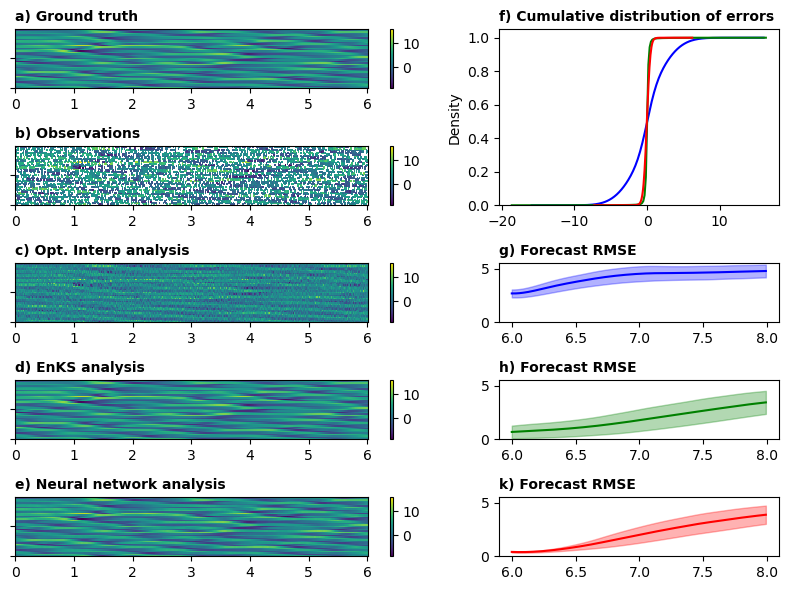

In [22]:
mosaic = """
aaaff
bbbff
cccgg
dddhh
eeekk
"""

fig, axd = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 6))

img_a = axd["a"].pcolor(analysis_time_labels, location_labels, ground_truths[0, 25:626].T, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(img_a, ax=axd["a"])
observations_view = observations[0, 25:626]
mask_bool = torch.logical_not(mask[0, 25:626].bool())
observations_view[mask_bool] = np.nan
img_b = axd["b"].pcolor(analysis_time_labels, location_labels,observations_view.T, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(img_b, ax=axd["b"])

img_c = axd["c"].pcolor(analysis_time_labels, location_labels,analysis_oi[0, 25:626].T, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(img_c, ax=axd["c"])
img_d = axd["d"].pcolor(analysis_time_labels, location_labels,analysis_enks[0, 25:626].T, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(img_d, ax=axd["d"])
img_e = axd["e"].pcolor(analysis_time_labels, location_labels,analysis[0, 25:626].T, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(img_e, ax=axd["e"])

sns.kdeplot(error_analysis_oi.flatten(), color='blue', ax=axd["f"], label='Opt. Interp.', cumulative=True)
sns.kdeplot(error_analysis_enks.flatten(), color='green', ax=axd["f"], label='Enks', cumulative=True)
sns.kdeplot(error_analysis_nn.flatten(), color='red', ax=axd["f"], label='NN', cumulative=True)

axd["g"].plot(forecast_time_labels, mean_error_oi, color="blue")
axd["g"].fill_between(forecast_time_labels, mean_error_oi-std_error_oi, mean_error_oi+std_error_oi, color="blue", alpha=0.3)
axd["g"].set_ylim(0, 5.5)
axd["h"].plot(forecast_time_labels, mean_error_enks, color="green")
axd["h"].fill_between(forecast_time_labels, mean_error_enks-std_error_enks, mean_error_enks+std_error_enks, color="green", alpha=0.3)
axd["h"].set_ylim(0, 5.5)
axd["k"].plot(forecast_time_labels, mean_error_nn, color="red")
axd["k"].fill_between(forecast_time_labels, mean_error_nn-std_error_nn, mean_error_nn+std_error_nn, color="red", alpha=0.3)
axd["k"].set_ylim(0, 5.5)

for letter, ax in axd.items():
    title = f"{letter}) "
    if letter == "a": title += "Ground truth"
    if letter == "b": title += "Observations"
    if letter == "c": title += "Opt. Interp analysis"
    if letter == "d": title += "EnKS analysis"
    if letter == "e": title += "Neural network analysis"
    if letter == "f": title += "Cumulative distribution of errors"
    if letter in ["g", "h", "k"]: title += "Forecast RMSE"
    ax.set_title(title, loc="left", fontsize=10, fontweight="bold")
    
    if letter in ["a", "b", "c", "d", "e"]:
        ax.set_yticklabels([])

plt.tight_layout()
plt.savefig("data_assimilation_example.png", dpi=300)

# Old code can be deleted if everything is ok

In [56]:
experiment_dir = "/gpfs/work/zinchenk/final_experiments/120324_try_batch_norm/data_assimilation/multirun/2024-03-12/22-03-06/5"
test_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-one_level-grid_40-forcing_8.0-dt_0.01-rk4.h5"
random_seed = 2510
device = "cuda" if torch.cuda.is_available() else "cpu"
drop_edge_samples = True

In [57]:
with h5py.File(test_data_path) as file:
    test_simulations = torch.from_numpy(file["first_level"][:]).to(device)

In [59]:
test_simulations.shape

torch.Size([1000, 1000, 40])

In [58]:
assimilation_network = load_data_assimilation_network(experiment_dir, device=device)
config = load_hydra_config(experiment_dir)

In [92]:
torch.manual_seed(random_seed)
pl.seed_everything(random_seed)

# instantiate observational model
observational_model = RandomObservationModel(
    additional_noise_std=config.datamodule.dataset.additional_noise_std,
    random_mask_fraction=config.datamodule.dataset.random_mask_fraction,
)

# instantiate dataset
dataset = L96InferenceDataset(
    ground_truth_data=test_simulations,
    observation_model=observational_model,
    input_window_extend=config.input_window_extend,
    drop_edge_samples=drop_edge_samples,
)

print(f"Number of samples: {len(dataset)}")

Global seed set to 2510


Number of samples: 951


In [93]:
integration_window = 150
forecast_window = 150

n_timesteps = integration_window + forecast_window

ground_truth = dataset.ground_truth[:, :n_timesteps].cpu()

observations = torch.zeros_like(ground_truth)
observations[:, :integration_window] = dataset.observations[:, :integration_window].cpu()
# cover missing values with np.nan
is_missing = torch.eq(observations, 0.)
observations = observations.masked_fill(is_missing, np.nan)


analysis = reconstruct_observations(dataset, assimilation_network)
analysis_and_forecast = torch.full_like(ground_truth, np.nan)
# insert part of the reconstruction
li = config.input_window_extend
ri = integration_window - config.input_window_extend
analysis_and_forecast[:, li:ri] = analysis[:, :ri-li].cpu()

# insert forecast from estimated initial state
initial_state = analysis_and_forecast[:, ri-1]
forward_operator = L96Simulator(forcing=8.0)
n_steps = analysis_and_forecast.shape[1] - ri
time = torch.arange(0, n_steps*0.01, 0.01)
rollout = forward_operator.integrate(time=time, state=initial_state).squeeze()
analysis_and_forecast[:, ri:] = rollout

difference = ground_truth[:, li:] - analysis_and_forecast[:, li:]
difference = torch.full_like(ground_truth, np.nan)
difference[:, li:] = ground_truth[:, li:] - analysis_and_forecast[:, li:]

/tmp/ipykernel_179862/2690499413.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtickslabels)


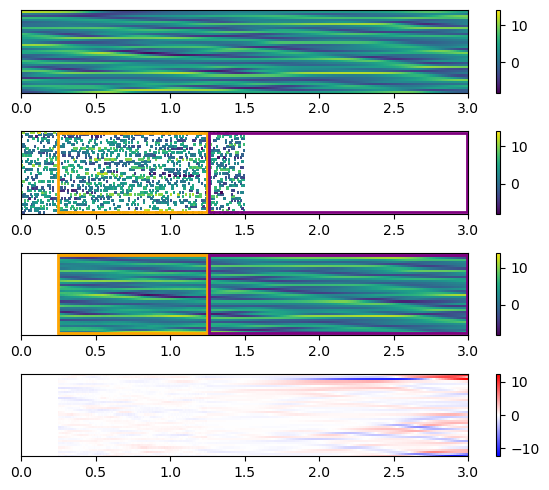

In [94]:
i_simulation = 26

fig, axes = plt.subplots(4, 1, figsize=(6, 5))

tmp = torch.stack([ground_truth[i_simulation], observations[i_simulation], analysis_and_forecast[i_simulation]])
vmin = torch.nan_to_num(tmp, nan=10e14).min()
vmax = torch.nan_to_num(tmp, nan=0).max()

img_gt = axes[0].pcolor(ground_truth[i_simulation].T, vmin=vmin, vmax=vmax)
img_obs = axes[1].pcolor(observations[i_simulation].T, vmin=vmin, vmax=vmax)
img_pred = axes[2].pcolor(analysis_and_forecast[i_simulation].T, vmin=vmin, vmax=vmax)

obs_reconstraction_box = patches.Rectangle((25, 1), 100, 38, linewidth=2, edgecolor='orange', facecolor='none', zorder=999)
obs_forecast_box = patches.Rectangle((126, 1), 173, 38, linewidth=2, edgecolor='purple', facecolor='none', zorder=999)
axes[1].add_patch(obs_reconstraction_box)
axes[1].add_patch(obs_forecast_box)

pred_reconstraction_box = patches.Rectangle((25, 1), 100, 38, linewidth=2, edgecolor='orange', facecolor='none', zorder=999)
pred_forecast_box = patches.Rectangle((126, 1), 173, 38, linewidth=2, edgecolor='purple', facecolor='none', zorder=999)
axes[2].add_patch(pred_reconstraction_box)
axes[2].add_patch(pred_forecast_box)

vlim = torch.nan_to_num(difference[i_simulation], nan=0).abs().max()
img_diff = axes[3].pcolor(difference[i_simulation].T, vmin=-vlim, vmax=vlim, cmap="bwr")

xticks = torch.arange(0, 301, 50)
xtickslabels = torch.arange(0, 3.1, 0.5).numpy()
for ax in axes:
    ax.set_yticks([])
    ax.set_xticklabels(xtickslabels)

plt.colorbar(img_gt, ax=axes[0])
plt.colorbar(img_obs, ax=axes[1])
plt.colorbar(img_pred, ax=axes[2])
plt.colorbar(img_diff, ax=axes[3])

plt.tight_layout()

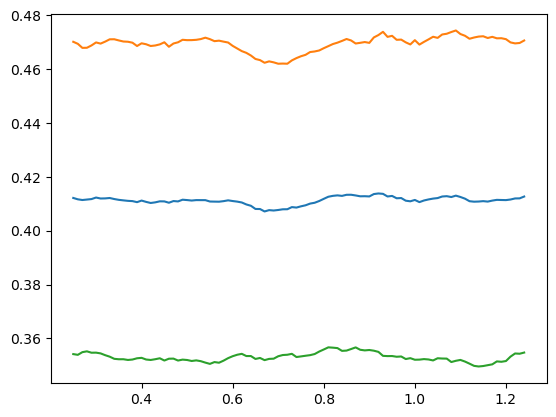

In [131]:
squered_errors = (analysis[:, :ri-li].cpu() - ground_truth[:, li:ri].cpu())**2
analysis_mean_errors = squered_errors.mean((-1, 0)).sqrt()
analysis_std_errors = squered_errors.mean((-1)).sqrt().std((0))

xticks_analysis = torch.arange(li, integration_window-li, 1)
xticklabels_analysis = xticks_analysis * 0.01

plt.plot(xticklabels_analysis, analysis_mean_errors)
plt.plot(xticklabels_analysis, analysis_mean_errors+analysis_std_errors)
plt.plot(xticklabels_analysis, analysis_mean_errors-analysis_std_errors)

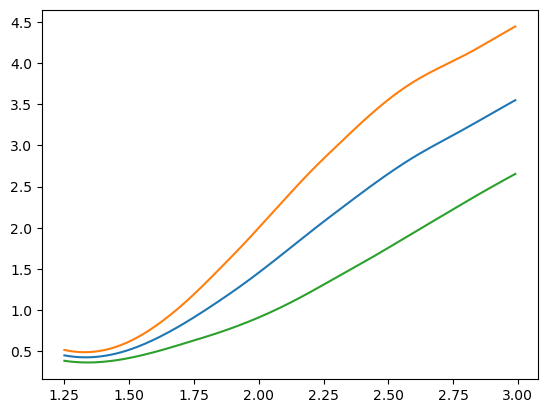

In [126]:
squered_errors = (analysis_and_forecast[:, ri:].cpu() - ground_truth[:, ri:].cpu())**2
forecast_mean_errors = squered_errors.mean((-1, 0)).sqrt()
forecast_std_errors = squered_errors.mean((-1)).sqrt().std((0))

xticks_forecast = torch.arange(integration_window-li, n_timesteps, 1)
xticklabels_forecast = xticks_forecast * 0.01

plt.plot(xticklabels_forecast, forecast_mean_errors)
plt.plot(xticklabels_forecast, forecast_mean_errors+forecast_std_errors)
plt.plot(xticklabels_forecast, forecast_mean_errors-forecast_std_errors)

In [148]:
xticks = torch.arange(0, 301, 50)
xtickslabels = torch.arange(0, 3.1, 0.5).numpy()

id_simulation = 1
the_ground_truth = ground_truth[id_simulation]
the_observations = observations[id_simulation]
the_analysis_and_forecast = analysis_and_forecast[id_simulation]
the_difference = difference[id_simulation]

/tmp/ipykernel_179862/2870886.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd["a"].set_xticklabels(xtickslabels)
/tmp/ipykernel_179862/2870886.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd["b"].set_xticklabels(xtickslabels)
/tmp/ipykernel_179862/2870886.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd["c"].set_xticklabels(xtickslabels)
/tmp/ipykernel_179862/2870886.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd["d"].set_xticklabels(xtickslabels)


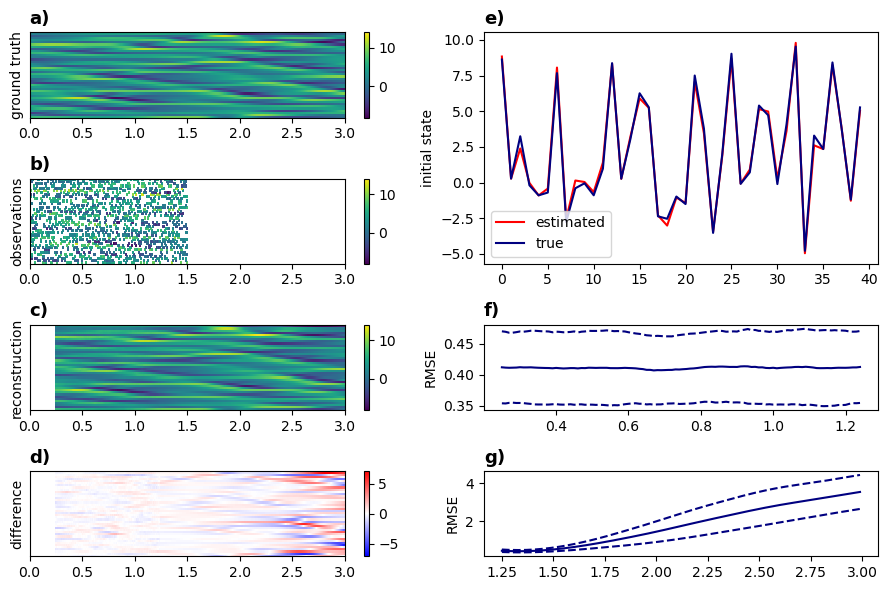

In [151]:
mosaic = """
aaee
bbee
ccff
ddgg
"""
fig, axd = plt.subplot_mosaic(mosaic=mosaic, figsize=(9, 6))

# A - ground truth simulation
img_gt = axd["a"].pcolor(the_ground_truth.T, vmin=vmin, vmax=vmax)
plt.colorbar(img_gt, ax=axd["a"])
axd["a"].set_xticklabels(xtickslabels)
axd["a"].set_ylabel("ground truth")
axd["a"].tick_params(left=False, labelleft=False)

# B - pseudo-observations
img_obs = axd["b"].pcolor(the_observations.T, vmin=vmin, vmax=vmax)
plt.colorbar(img_obs, ax=axd["b"])
axd["b"].set_xticklabels(xtickslabels)
axd["b"].set_ylabel("observations")
axd["b"].tick_params(left=False, labelleft=False)

# C - reconstruction and forecast
img_pred = axd["c"].pcolor(the_analysis_and_forecast.T, vmin=vmin, vmax=vmax)
plt.colorbar(img_pred, ax=axd["c"])
axd["c"].set_xticklabels(xtickslabels)
axd["c"].set_ylabel("reconstruction")
axd["c"].tick_params(left=False, labelleft=False)

# D - difference between groud truth and reconstraction/forecast
vlim = torch.nan_to_num(the_difference, nan=0).abs().max()
img_diff = axd["d"].pcolor(the_difference.T, vmin=-vlim, vmax=vlim, cmap="bwr")
plt.colorbar(img_diff, ax=axd["d"])
axd["d"].set_xticklabels(xtickslabels)
axd["d"].set_ylabel("difference")
axd["d"].tick_params(left=False, labelleft=False)

# E - initial condition error
the_estimated_initial_state = initial_state[id_simulation]
the_true_initial_state = ground_truth[id_simulation, ri-1]
axd["e"].plot(the_estimated_initial_state, label="estimated", color="red")
axd["e"].plot(the_true_initial_state, label="true", color="navy")
axd["e"].legend()
axd["e"].set_ylabel("initial state")

# F - analysis error
axd["f"].plot(xticklabels_analysis, analysis_mean_errors, color="navy")
axd["f"].plot(xticklabels_analysis, analysis_mean_errors+analysis_std_errors, color="navy", ls="--")
axd["f"].plot(xticklabels_analysis, analysis_mean_errors-analysis_std_errors, color="navy", ls="--")
axd["f"].set_ylabel("RMSE")

# G - forecast error
axd["g"].plot(xticklabels_forecast, forecast_mean_errors, color="navy")
axd["g"].plot(xticklabels_forecast, forecast_mean_errors+forecast_std_errors, color="navy", ls="--")
axd["g"].plot(xticklabels_forecast, forecast_mean_errors-forecast_std_errors, color="navy", ls="--")
axd["g"].set_ylabel("RMSE")

for letter, ax in axd.items():
    ax.set_title(f"{letter})", loc="left", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.savefig("data_assimilation_example.png", dpi=300)